1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [2]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

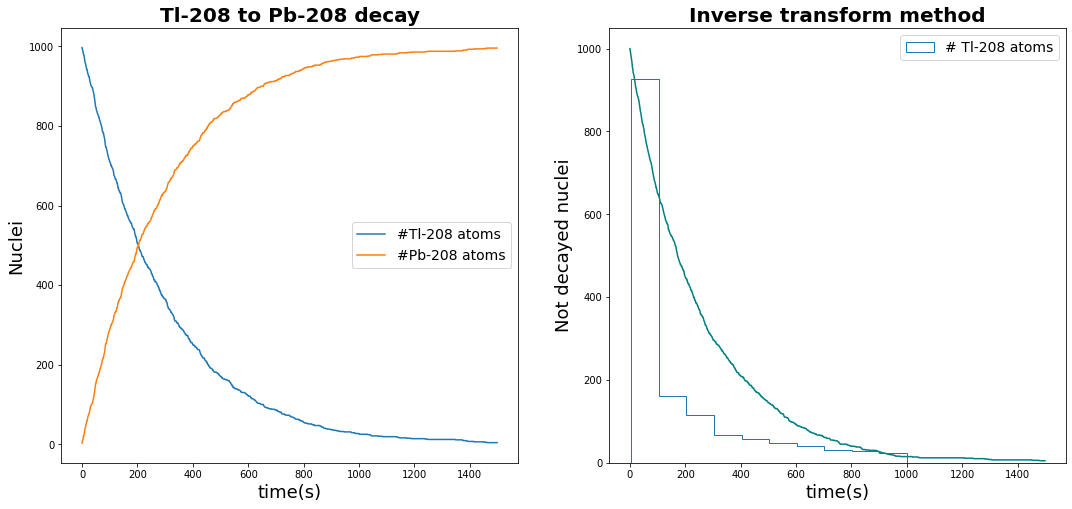

In [5]:
tau = 3.052*60 
Tl_i = 1000   
Pb_i = 0
Tl_t = []
Pb_t = []
time_frame = np.arange(1500)

def p(t):
    return 1 - 2**(-t/tau)


for t in time_frame:
    for i in range(Tl_i):
        x = np.random.uniform()
        if x < p(1):   #if random number in 0, 1 < probability of decaying at a given step --- > atom decays
            Tl_i -= 1
            Pb_i += 1
            if Tl_i == 0: 
                break
    Tl_t.append(Tl_i)
    Pb_t.append(Pb_i)

    
#Inverse problem

def icdf(x):
    return -tau*np.log2(1 - x) 


u = np.random.random(1000)
v = icdf(u)
not_decayed = [v[v>i].shape[0] for i in time_frame]

#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,8))
ax1.plot(time_frame, Tl_t, label = '#Tl-208 atoms')
ax1.plot(time_frame, Pb_t, label = '#Pb-208 atoms')
ax1.set_title('Tl-208 to Pb-208 decay', fontweight = 'heavy', size=20)
ax1.set_ylabel('Nuclei', fontsize = 18)
ax1.set_xlabel('time(s)', fontsize = 18)
ax1.legend(loc='best', fontsize=14)
ax2.set_title('Inverse transform method', fontweight = 'heavy', size=20)
ax2.set_ylabel('Not decayed nuclei', fontsize = 18)
ax2.set_xlabel('time(s)', fontsize = 18)
ax2.hist(not_decayed, histtype='step', label = '# Tl-208 atoms')
ax2.plot(time_frame, not_decayed, color = 'teal')
ax2.legend(loc = 'best', fontsize = 14)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [3]:
alpha = 1000000
Z = 79
e = 1.602176634E-19 
a0 = 5.291777721092E-11
eps0 = 8.85418781762E-12


E = 7.7*1000000*e

sigma = a0/100
x = np.random.normal(0, sigma, alpha)
y = np.random.normal(0, sigma, alpha)

#threshold angle x is pi/2. So tan(x/2) = tan(45) = 1 
#Any particle with impact parameter smaller than b_thresh bounces back
b_thresh = (Z*e**2)/(2*np.pi*eps0*E)


bounce_back_counter = 0
for i in range(alpha):
    b_i = np.sqrt(x[i]**2 + y[i]**2) #Impact parameter of the i_th particle
    if b_i < b_thresh: #check 
        bounce_back_counter += 1
        
print('Fraction of particles returning is: ', bounce_back_counter/alpha)

Fraction of particles returning is:  0.001497


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [4]:
def f(x):
    return (np.sin(1/( x*(2-x) ) ))**2


#hit miss

N=100000
count=0

for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y < f(x):
        count+=1
        
integral_hitmiss=2*count/N

#mean value

x_mv = 2*np.random.random(N)
integral_meanvalue = (2/N)*np.sum(f(x_mv))

integral_true = 1.4514
print('The actual result of the integral is: ', integral_true)

print('Hit-miss method returned an integral of', np.round(integral_hitmiss, 4), 'with absolute error', np.round(100*abs(integral_true-integral_hitmiss)/integral_true, 4), '%')
print('Mean value method returned an integral of', np.round(integral_meanvalue, 4), 'with absolute error', np.round(100*abs(integral_true-integral_meanvalue)/integral_true, 4), '%')



The actual result of the integral is:  1.4514
Hit-miss method returned an integral of 1.4505 with absolute error 0.062 %
Mean value method returned an integral of 1.4501 with absolute error 0.0901 %


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [5]:
#Area of circle of unit radius

count = 0
N = 1000000

for i in range(0, N):
    x = np.random.uniform(0,1)
    y = np.random.uniform(0,1)
    if np.sqrt(x**2 + y**2) <= 1.0:
        count += 1

res = 4 * (float(count) / N)
print('Area of circle of unit radius with hit-miss is', res)

#10D case

def sphere_unit_radius(x):
    if( np.linalg.norm(x)<= 1):
        return 1
    else:
        return 0

count10D = 0
d = 10
for i in range(N):
    count10D+=sphere_unit_radius(np.random.random(d))

integral_10D = (count10D*(2**d))/N

print('Area of 10D sphere of unit radius with hit-miss is', integral_10D)





Area of circle of unit radius with hit-miss is 3.143184
Area of 10D sphere of unit radius with hit-miss is 2.482176


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

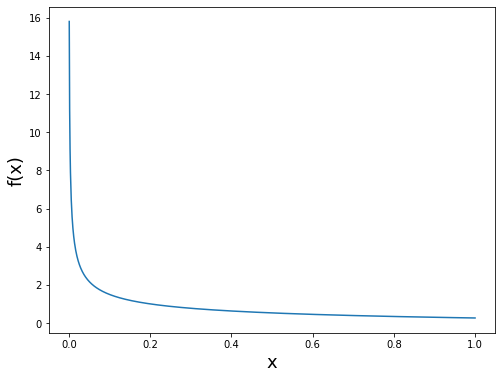

The integral of the function with importance sampling is 0.839716


In [6]:
from scipy.integrate import quad

def f(x):
    return 1/( np.sqrt(x) * (np.exp(x)+1) )

def w(x):
    return 1/np.sqrt(x)

# plot function to integrate
xs = np.delete(np.linspace(0, 1, 1000), 0)
plt.figure(figsize=(8,6))
plt.plot(xs,f(xs))
plt.ylabel('f(x)', fontsize = 18)
plt.xlabel('x', fontsize = 18)
plt.show()



N = 100000
y = np.random.uniform(0,1,N)**2 #given the shape of the function we concentrate the values around 0
weight_integral = 2 # integral of weight function in domain, done analytically
integral_importance = np.sum(f(y)/w(y))*weight_integral/N

print('The integral of the function with importance sampling is', np.round(integral_importance, 6))
